## **Dataloaders**

**Imports**

*You can find the documentation and a brief explanation of the libraries we're importing (or their features) below.*

* [Docs](https://pytorch.org/docs/stable/data.html) for `Dataset`

* [Docs]( https://pytorch.org/vision/stable/datasets.html) for `datasets` 
  * "All datasets are subclasses of the torch.utils.data.Dataset class...

* [Docs]( https://pytorch.org/vision/stable/transforms.html) for `ToTensor`
  * [Illustration](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) of `transforms`
  * A Tensor image is a tensor with (Channels, Height, Width) shape
  * Transformations that accept a Tensor image also accept a batch of tensors
  * A batch of tensors can be described by (Number of Images in a Batch, Channels, Height, Width)
  * Given that we're trying to analyze videos, my guess is that we'll be using tensors of the latter shape
  * Let's see if my guess comes true, haha!

* [Docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) for `PyPlot`
  * Fairly simple, I guess. Matplotlib is, well, matplotlib.

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

* [Docs](https://docs.python.org/3/library/os.html) for `os`
  * I saw on Eustis' video that we're going to be working with paths
  * I'm guessing this import is to help with that

* [Docs](https://pytorch.org/vision/stable/io.html) for `torchvision.io`
  * torchvision.io is apparently to handle input output operations
  * They are currently apparently specific to reading and writing video and images

* [Docs](https://docs.python.org/3/library/glob.html) for `glob`
  * As per Eustis, glob apparently is a faster way to search folders

In [4]:
import os
from torchvision.io import read_video
import glob

## **Creating the CustomImageDataset Class**

CustomImageDataset extends our `torch.utils.data.Dataset` class, which we imported earlier. A detailed explanantion of teh class' definiton and its methods can be found below the code defining the class.

There is a [syntax](https://stackoverflow.com/questions/64933298/why-should-we-use-in-def-init-self-n-none) using which we can declare the return type of the constructor (`__init__` function) as `None` (or `NoneType`)

In [5]:
class CustomImageDataset(Dataset): 
    
    def __init__(self, root_path, to_be_trained):
        # Remember, the model has to be trained when it is initialized. 
        # The below code is mostly to train the model on initialization.

        # root_path is the path to the dataset

        # Declaring Instance Variables  
        self.num_fpv = 150 # Number of frames per video
        self.paths = [] # A list of paths to all the individual videos in our training set

        # Populating self.paths with the required data 

        folders = glob.glob(root_path) 

        for sub_folders in folders: # Loop 1
            labels = glob.glob(sub_folders)
            if ((to_be_trained == True) and ("train" in label)):
                for label in labels: # Loop 2
                    videos = glob.glob(label + "/.avi")
                    for path_to_video in videos: # Loop 3
                        self.paths.append(path_to_video)

    def __len__(self):
        return len(self.paths) * self.num_fpv
    
    def __getItem__(self, frame_index):
        video_index = frame_index // self.num_fpv
        frame_index_inside_video = frame_index % self.num_fpv

        video_path = self.paths[video_index]
        video_tensor = read_video(video_path)
        video_tensor_frames_parameter = video_tensor[0]
        frame_image = video_tensor_frames_parameter[frame_index_inside_video]

        label = not ("NonFight" in video_path) 
        # Returns true when "NonFight" in video_path is false, i.e. when the label is "Fight"
        # Returns false when "NonFight" in video_path is true, i.e. when the label is "NonFight"

        return frame_image, label


## **The `__init__` function**

*The Function Header* 

* The function takes in two input parameters, a string `root_path` and a boolean `to_be_trained`.
* For this branch, the `root_path` variable that we have to pass to the constructor of the CustomImageDataset class is `Users/akash.arunabharathi/CS196/RWF2000 – CS196 Dataset`

The file structure in the above directory looks like this:

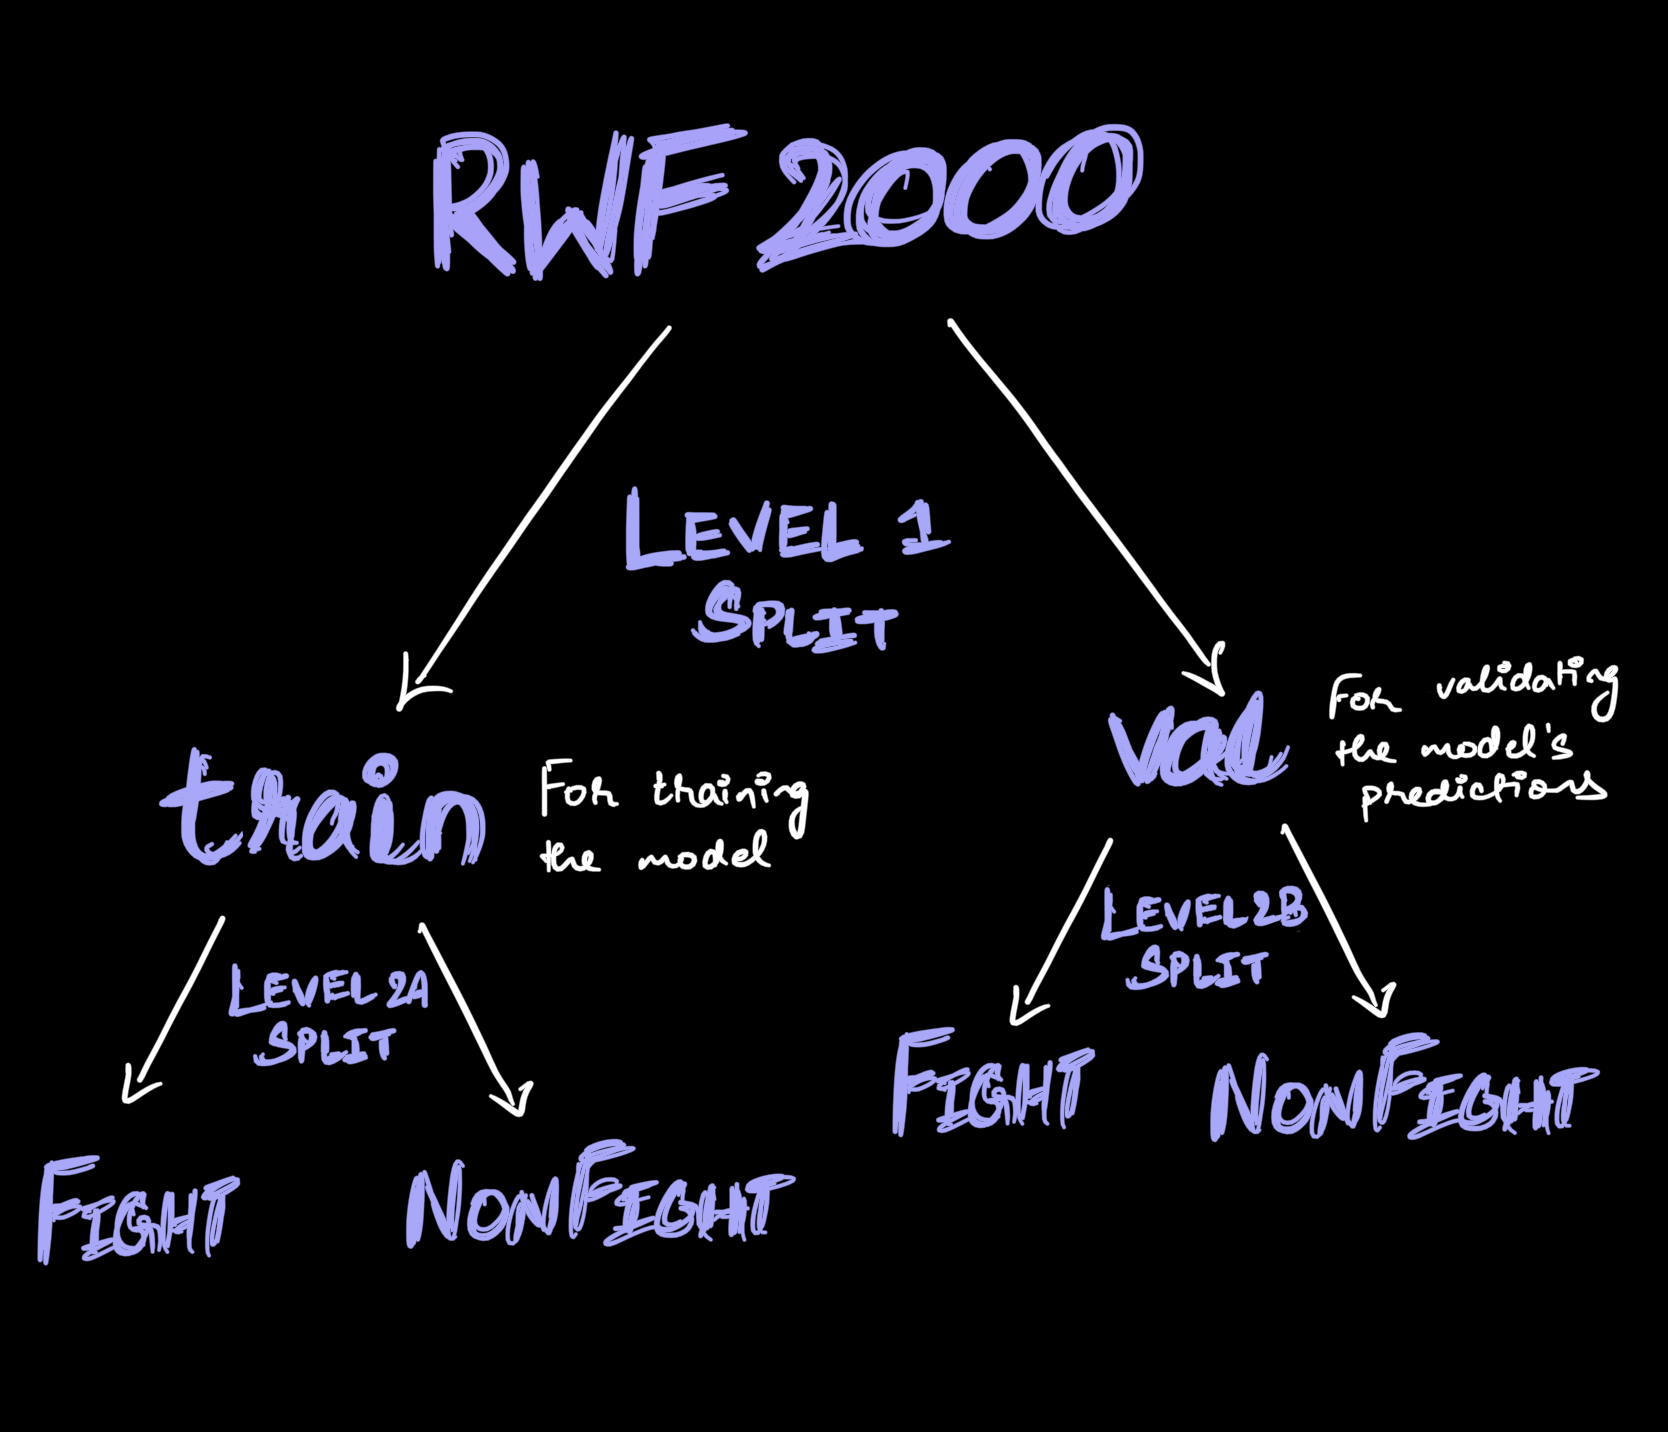

In [1]:
from IPython import display
display.Image("RWF2000_CS196_Dataset_File_Structure.jpeg")

## **Populating `self.paths` with the the training set data**

I think the statement `folders = glob.glob(root_path)` will return the paths to the `train` and `val` folders as part of an iterable.

For the `for` loop, I have a whole theory.

`sub_folders` corresponds to the *Level 1* split from the diagram. I expect `sub_folder` to be `train` on one iteration and`val` on the next iteration.

Once we're inside **Loop 1**, I think `labels = glob.glob(sub_folders)` will return the paths to the `Fight` and `NonFight` folders under each `sub_folder` in one iteration. `labels`, I believe, corresponds to the *Level 2* split from the diagram. 

Before moving into Loop 2, we must remember that we want our model to be trained only on the training set, which is under the `train` folder in the dataset. So we check if we want to train the model (through the `to_be_trained` variable) and check if "train" is in the path to the ;label we're currently iterating through. If yes, we move onto **Loop 2**.

Once, we're in **Loop 2**, I think the following happens:

* When `sub_folder` corresponds to the `train` folder, I expect `label` to correspond to the *Level 2A* split
    * `label` will be `Fight` on one iteration and `NonFight` on the other
* When `sub_folder` corresponds to the `val` folder, I expect `label` to correspond to the *Level 2B* split
    * As before, `label` will be `Fight` on one iteration and `NonFight` on the other

Then comes **Loop 3** – this one's fairly simple. In **Loop 2**, we selected the videos through the statement `videos = glob.glob(label + "/.avi")` and now, we iterate through all the paths in each of the `Fight` and `NonFight` folders, one at a time. This `for` loop will run many as times as there are individual examples in either `Fight`/`NonFight`, depending upon which iteration and which `sub_folder` we're in. All the paths to the videos will now be added to the instance variable `self.paths`.

## **The `__len__` function**

* The `__len__` function can be called without the dot notation too, by passing the instance of `CustomImageDataset` as an argument.

We return the number of videos we have (`len(self.paths)` returns the number of paths we have in our training set, which is the number of videos we have) multipled by the number of frames in each video. So, the `__len__` function essentially returns the number of frames our training set has.

## **The `__getItem__` function**

* The `__getItem__` function takes in one argument, `frame_index`. This can be anywhere between 0 and len(Instance of CustomImageDataset).

* In case `__getItem__` is not called using dot notation, it would take in two arguments, one being an instance of `CustomImageDataset` and another being `frame_index`, as discussed above.

For the `__getItem__` function, we return a frame a specific video along with the label of the video. The operation to calculate `video_index` helps us figure out which video we're talking about, while the operation to compute `frame_index_inside_video` helps us figure out the required frame's index inside the video.

`read_video()` converts the abovementioned video to a tensor – the first channel in the tensor actually corresponds to the frames in the video. We index into this using `frame_index_inside_video`, and store the requisite frame in `frame_image`. Additionally, since we need to return the label of the video sample as well, we initialize boolean variable `label` to store this data. 

We compute this using the expression we used since the statement `"Fight" in video_path` would also be true given the fact that both `"Fight"` and `"NonFight"` have the word `"Fight"` in them.

Then, we return `frame_image` and `label`.